In [62]:
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_33927/2183475185.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(r**2 - y**2)


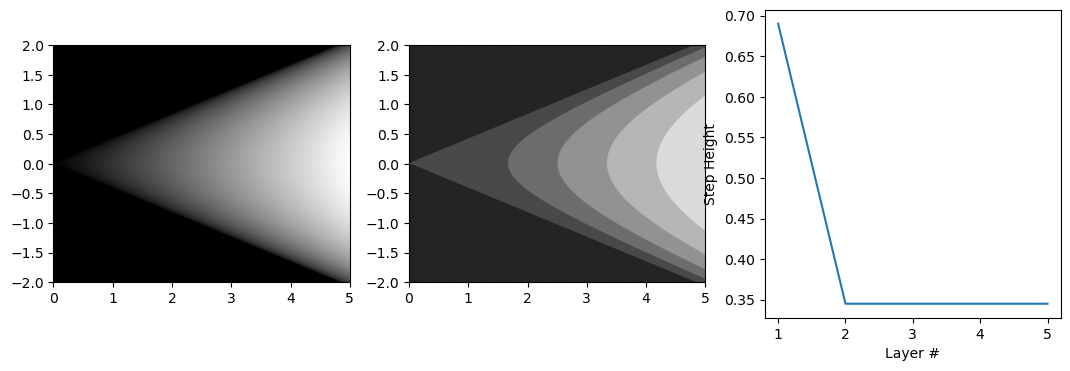

In [63]:
def cone_height(x, y) :
    tip_angle = np.pi/4
    r = (np.tan(tip_angle*0.5)) * x
    return np.sqrt(r**2 - y**2)

xr = (0,5)
yr = (-2,2)
px = 3e-3

x = np.arange(*xr, px)
y = np.arange(*yr, px)
X, Y = np.meshgrid(x, y)

height = cone_height(X, Y)
height = np.nan_to_num(height, 0)

# Display height (depth)
fig, axs = plt.subplots(1,3)
plt.subplot(1,3,1)
plt.imshow(height, cmap="gray", extent=(*xr, *yr))
plt.clim(vmin=0)
plt.gca().set_aspect(1)

plt.subplot(1,3,2)
n_layers = 5
_, edges = np.histogram(height, bins=n_layers+1)

# In the biz we call this "cheating"
edges[1] = 1e-10

hbinned = np.digitize(height, edges)
plt.imshow(hbinned, cmap="gray", extent=(*xr, *yr))
plt.clim(vmin=0)
plt.gca().set_aspect(1)
plt.subplot(1,3,3)
plt.plot(np.arange(n_layers)+1, np.diff(edges)[1:])
plt.ylabel("Step Height")
plt.xlabel("Layer #")
# plt.gca().set_aspect(1)

# plt.tight_layout()
fig.set_size_inches(13,4)


In [64]:
from PIL import Image

per_data = np.zeros((*hbinned.shape, 4), dtype=np.uint8)
stacked_data = np.copy(per_data)

for i in range(2, np.max(hbinned)):
    per_data = per_data * 0
    # plt.figure()
    # plt.imshow(hbinned==i)
    # Set RGB to gray (128, 128, 128) and Alpha to 255 where True
    row = [*[(i-1) * 255 / n_layers]*3, 255]
    per_data[hbinned==i,:] = row 
    stacked_data[hbinned==i,:] = row
    # print(data.dtype)
    Image.fromarray(per_data).save(f'3D_outputs/slice_{i-1:>03}.png')

Image.fromarray(stacked_data).save(f'3D_outputs/together.png')

In [70]:
import cv2
import ezdxf
def export_raw_contours_to_dxf(input_path, output_path, scale=1.0):
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 1. Use 'R12' - this is the "Golden Standard" for industrial compatibility
    doc = ezdxf.new('R12') 
    msp = doc.modelspace()

    for cnt in contours:
        if len(cnt) < 2: continue
        
        # Flatten and scale points
        points = cnt.reshape(-1, 2).astype(float) * scale
        
        # 2. Convert to list of (x, y) tuples
        points_list = [tuple(p) for p in points]
        
        # 3. Add a standard POLYLINE (dxfattribs is required to ensure it is closed)
        # R12 defaults to heavyweight polylines
        msp.add_polyline2d(points_list, dxfattribs={'flags': 1}) # flag 1 = closed

    doc.saveas(output_path)
for i in range(1, n_layers+1):
    export_raw_contours_to_dxf(f'3D_outputs/slice_{i:>03}.png', f'3D_outputs/SVG_{i:>03}.dxf')

Drawing units ($INSUNITS) are not exported for DXF R12.
Drawing units ($INSUNITS) are not exported for DXF R12.
Drawing units ($INSUNITS) are not exported for DXF R12.
Drawing units ($INSUNITS) are not exported for DXF R12.
Drawing units ($INSUNITS) are not exported for DXF R12.
